Avocado Price Forecasting

To predict / forecast the average price of Avocado based on time series data.


What you will learn :
- Statistical Tests for Time Series Analysis.
- Order selection for ARIMA & SARIMA models.
- In-sample and Out-of-sample forecasting using rolling and non-rolling methods.
- Difference between forecast function and predict function of ARIMA & SARIMA

Dataset Attributes

- Date :The date of the observation
- AveragePrice : the average price of a single avocado
- Total Volume : Total number of avocados sold
- 4046 : Total number of avocados with PLU 4046 sold
- 4225 : Total number of avocados with PLU 4225 sold
- 4770 : Total number of avocados with PLU 4770 sold
- Total Bags : Total number of bags
- Small Bags : Total number of small bags
- Large Bags : Total number of large bags
- XLarge Bags : Extra Large Bags
- type : conventional or organic
- year : year of the date
- region : the city or region of the observation

Dataset Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

In [2]:
data = pd.read_csv('avocado.csv')
data = data.drop('Unnamed: 0',axis = 1)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


In [3]:
data.shape

(18249, 13)

In [4]:
data.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


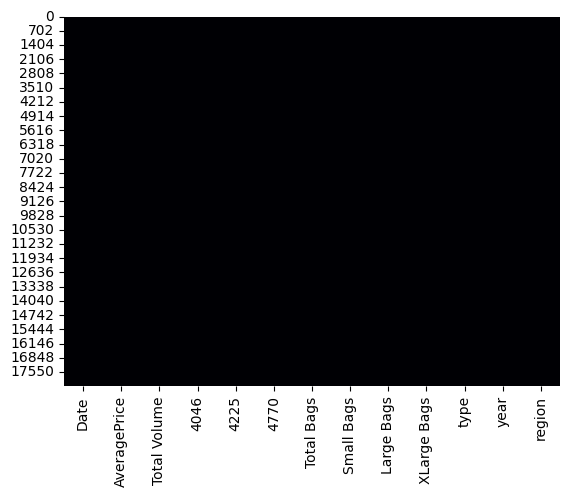

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
AveragePrice,18249.00,1.41,0.40,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.00,850644.01,3453545.36,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.00,293008.42,1264989.08,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.00,295154.57,1204120.40,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.00,22839.74,107464.07,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.00,239639.20,986242.40,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.00,182194.69,746178.51,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.00,54338.09,243965.96,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.00,3106.43,17692.89,0.00,0.00,0.00,132.50,551693.65
year,18249.00,2016.15,0.94,2015.00,2015.00,2016.00,2017.00,2018.00


In [8]:
df1 = data.copy(deep=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

# Resample hanya kolom numerik
df_num = df1.select_dtypes(include=['number']).resample('W').sum()

# Untuk kolom kategorikal, bisa ambil mode (nilai yang paling sering muncul)
df_cat = df1[['type', 'region']].resample('W').agg(lambda x: x.mode()[0])

# Gabungkan kembali
df1 = pd.concat([df_num, df_cat], axis=1)

df1.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,type,region
Date,,,,,,,,,,,,
2015-01-04,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,217620,conventional,Albany
2015-01-11,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,217620,conventional,Albany
2015-01-18,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,217620,conventional,Albany
2015-01-25,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,217620,conventional,Albany
2015-02-01,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,217620,conventional,Albany


Exploratory Data Analysis (EDA)

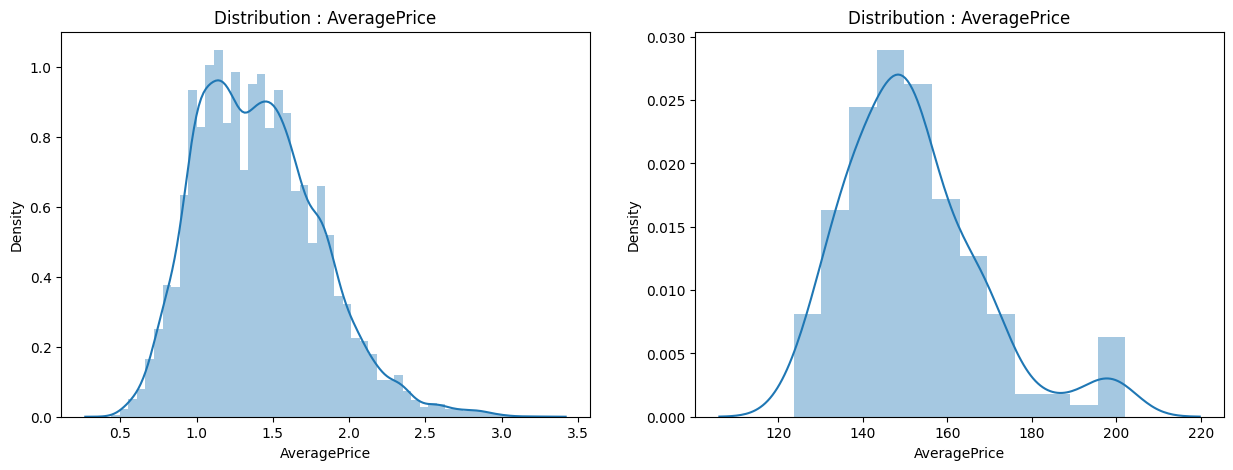

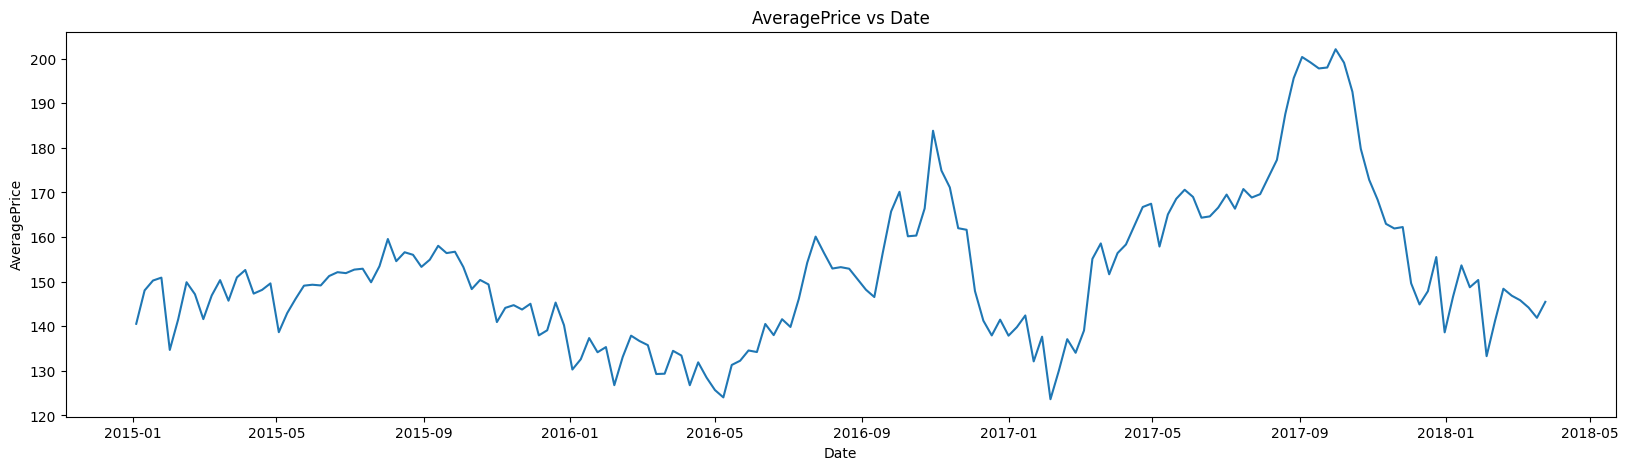

In [9]:
# Target Variable Visualization (AveragePrice) :

color1 = ["#299232","#20684E"]
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
sns.distplot(data['AveragePrice']);
plt.title('Distribution : AveragePrice')

plt.subplot(1,2,2)
sns.distplot(df1['AveragePrice']);
plt.title('Distribution : AveragePrice')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df1.index ,y = 'AveragePrice',data = df1,palette = color1);
plt.title('AveragePrice vs Date')

plt.show()
fig.tight_layout(pad = 2)

In [10]:
# Dividing features into Numerical and Categorical :

col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

numerical_features.remove('Date')
numerical_features.remove('AveragePrice')
numerical_features.remove('region')
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : type year
Numerical Features : Total Volume 4046 4225 4770 Total Bags Small Bags Large Bags XLarge Bags


In [11]:
# Distribution of Categorical Features :

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['type'] = le.fit_transform(data['type'])

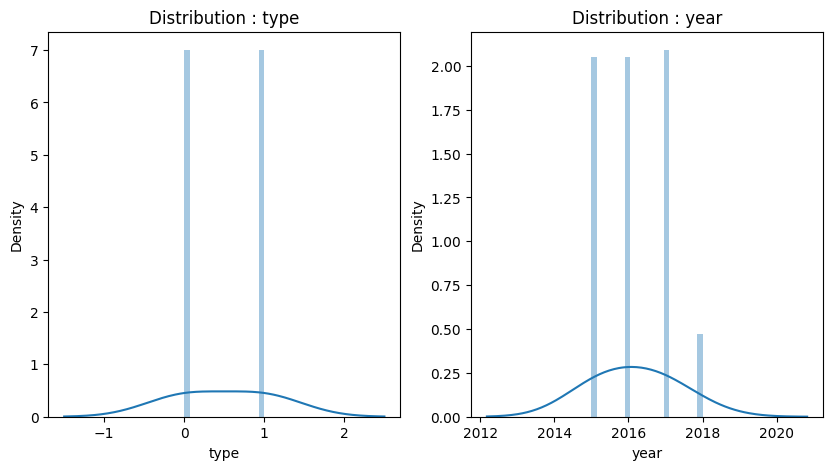

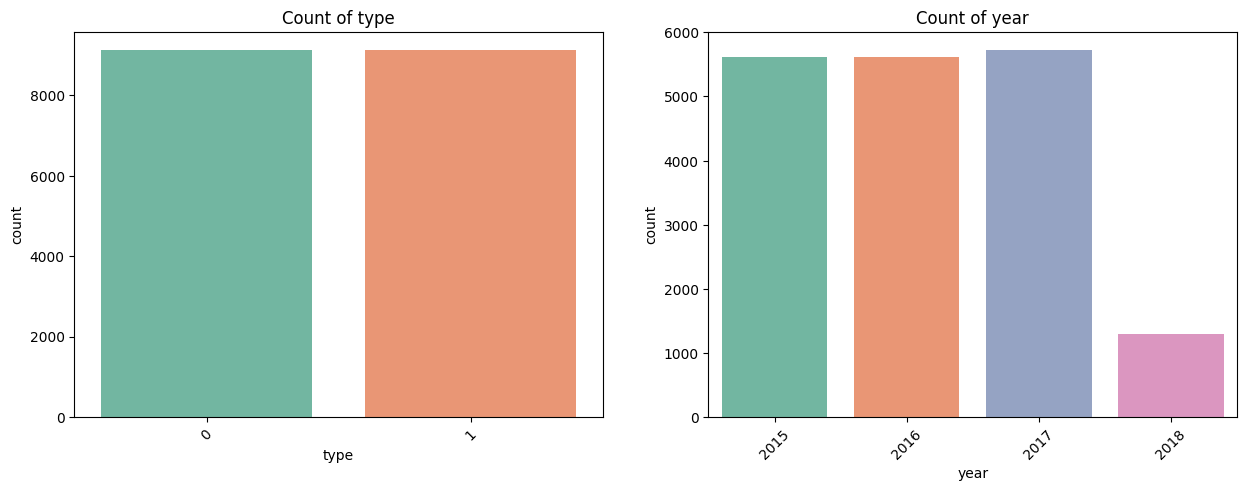

In [12]:
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
for i in range(len(categorical_features)):
    
    plt.subplot(1,2,i+1)
    sns.distplot(data[categorical_features[i]],kde_kws = {'bw' : 1});
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
    
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(15,5))

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=data, palette="Set2", ax=axes[i])
    axes[i].set_title(f"Count of {col}")
    axes[i].tick_params(axis='x', rotation=45) 



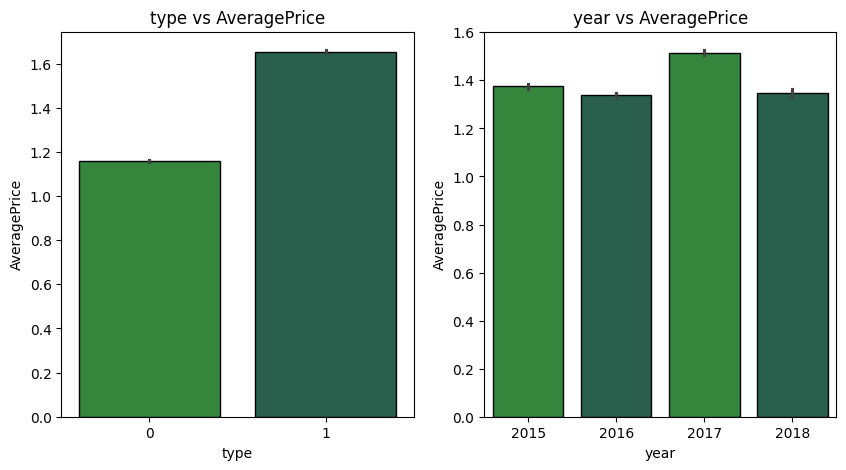

In [13]:
# Categorical Features vs Target Variable (AveragePrice) :

fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (10,5))
for i in range(len(categorical_features)):
    
    plt.subplot(1,2,i+1)
    sns.barplot(x = categorical_features[i],y = 'AveragePrice',data = data,palette = color1,edgecolor = 'black')
    title = categorical_features[i] + ' vs AveragePrice'
    plt.title(title);

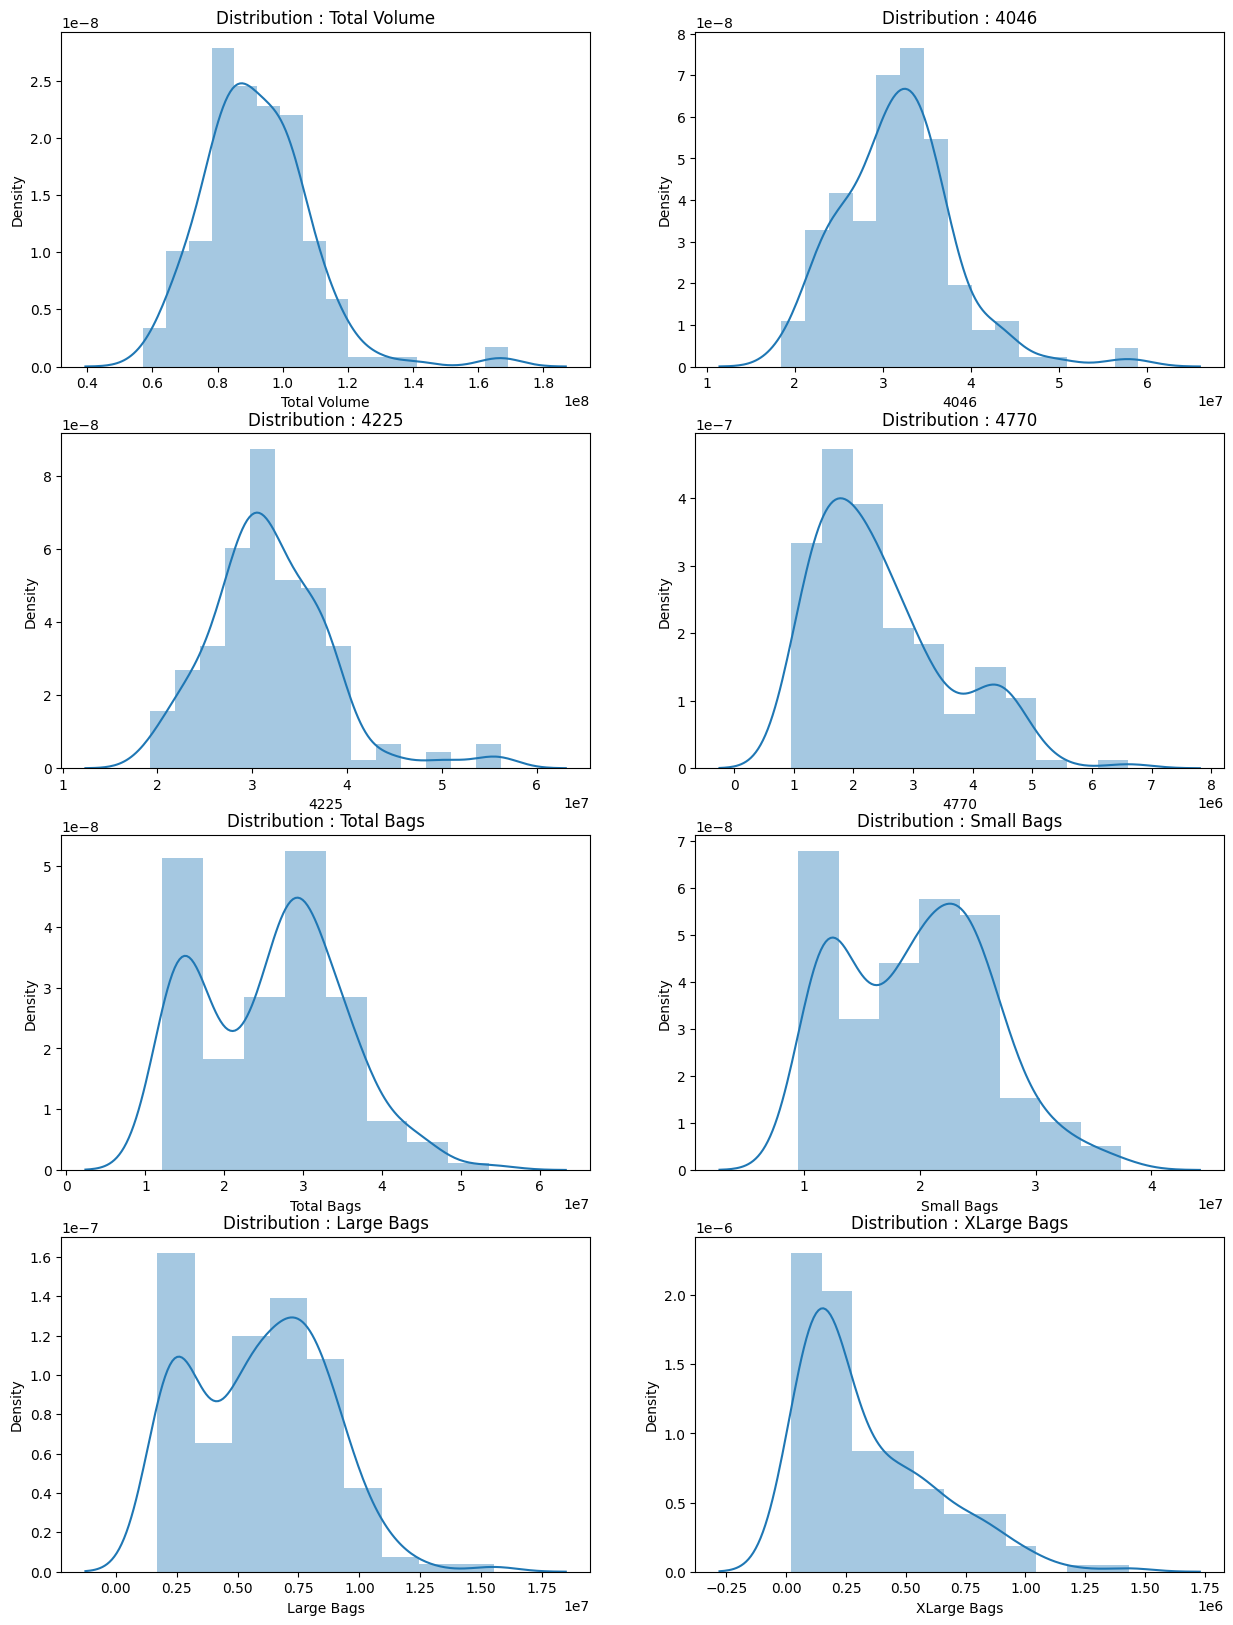

In [14]:
# Distribution of Numerical Features :

fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (15,20))
for i in range(len(numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(df1[numerical_features[i]])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()
fig.tight_layout(h_pad = 10,w_pad = 5)

In [15]:
# Numerical Features vs type :

total_volume = [sum(data[data['type'] == 0]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['type'] == 1]['Total Volume']) / sum(data['Total Volume']) * 100]

avocado_4046 = [sum(data[data['type'] == 0]['4046']) / sum(data['4046']) * 100,
                sum(data[data['type'] == 1]['4046']) / sum(data['4046']) * 100]

avocado_4225 = [sum(data[data['type'] == 0]['4225']) / sum(data['4225']) * 100,
                sum(data[data['type'] == 1]['4225']) / sum(data['4225']) * 100]

avocado_4770 = [sum(data[data['type'] == 0]['4770']) / sum(data['4770']) * 100,
                sum(data[data['type'] == 1]['4770']) / sum(data['4770']) * 100]

total_bags = [sum(data[data['type'] == 0]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['type'] == 1]['Total Bags']) / sum(data['Total Bags']) * 100]

small_bags = [sum(data[data['type'] == 0]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['type'] == 1]['Small Bags']) / sum(data['Small Bags']) * 100]

large_bags = [sum(data[data['type'] == 0]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['type'] == 1]['Large Bags']) / sum(data['Large Bags']) * 100]

xlarge_bags = [sum(data[data['type'] == 0]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['type'] == 1]['XLarge Bags']) / sum(data['XLarge Bags']) * 100]

type_numerical_features_percentage = [total_volume,avocado_4046,avocado_4225,avocado_4770,
                          total_bags,small_bags,large_bags,xlarge_bags]

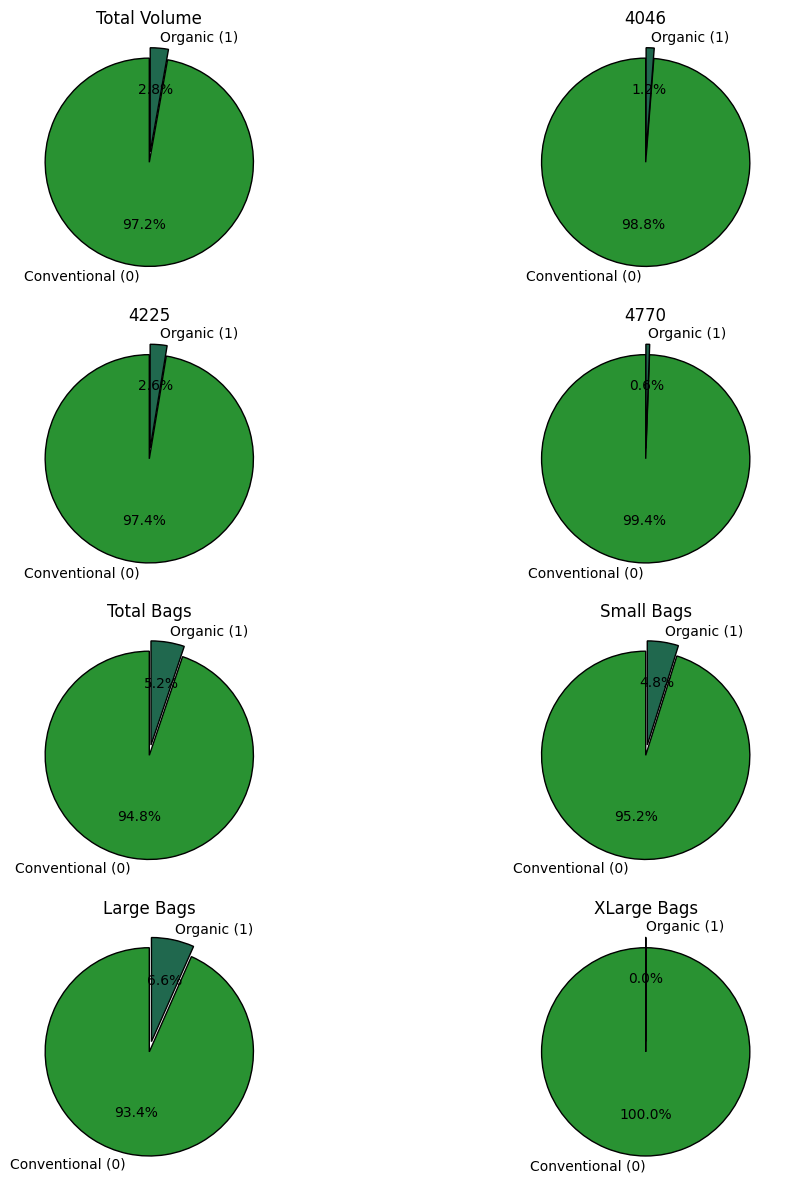

In [16]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (12,12))

for i in range(len(numerical_features)):
    plt.subplot(4,2,i + 1)
    plt.pie(type_numerical_features_percentage[i],labels = ['Conventional (0)','Organic (1)'],autopct = '%1.1f%%',
            startangle = 90, explode = (0,0.1), colors = color1, 
            wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
    title = numerical_features[i]
    plt.title(title);
        
fig.tight_layout(pad = 1)

In [17]:
# Numerical Features vs year :
    
total_volume = [sum(data[data['year'] == 2015]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2016]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2017]['Total Volume']) / sum(data['Total Volume']) * 100,
                sum(data[data['year'] == 2018]['Total Volume']) / sum(data['Total Volume']) * 100]

avocado_4046 = [sum(data[data['year'] == 2015]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2016]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2017]['4046']) / sum(data['4046']) * 100,
                sum(data[data['year'] == 2018]['4046']) / sum(data['4046']) * 100]

avocado_4225 = [sum(data[data['year'] == 2015]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2016]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2017]['4225']) / sum(data['4225']) * 100,
                sum(data[data['year'] == 2018]['4225']) / sum(data['4225']) * 100]

avocado_4770 = [sum(data[data['year'] == 2015]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2016]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2017]['4770']) / sum(data['4770']) * 100,
                sum(data[data['year'] == 2018]['4770']) / sum(data['4770']) * 100]

total_bags = [sum(data[data['year'] == 2015]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2016]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2017]['Total Bags']) / sum(data['Total Bags']) * 100,
              sum(data[data['year'] == 2018]['Total Bags']) / sum(data['Total Bags']) * 100]

small_bags = [sum(data[data['year'] == 2015]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2016]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2017]['Small Bags']) / sum(data['Small Bags']) * 100,
              sum(data[data['year'] == 2018]['Small Bags']) / sum(data['Small Bags']) * 100]

large_bags = [sum(data[data['year'] == 2015]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2016]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2017]['Large Bags']) / sum(data['Large Bags']) * 100,
              sum(data[data['year'] == 2018]['Large Bags']) / sum(data['Large Bags']) * 100]

xlarge_bags = [sum(data[data['year'] == 2015]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2016]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2017]['XLarge Bags']) / sum(data['XLarge Bags']) * 100,
               sum(data[data['year'] == 2018]['XLarge Bags']) / sum(data['XLarge Bags']) * 100]

year_numerical_features_percentage = [total_volume,avocado_4046,avocado_4225,avocado_4770,
                                      total_bags,small_bags,large_bags,xlarge_bags]

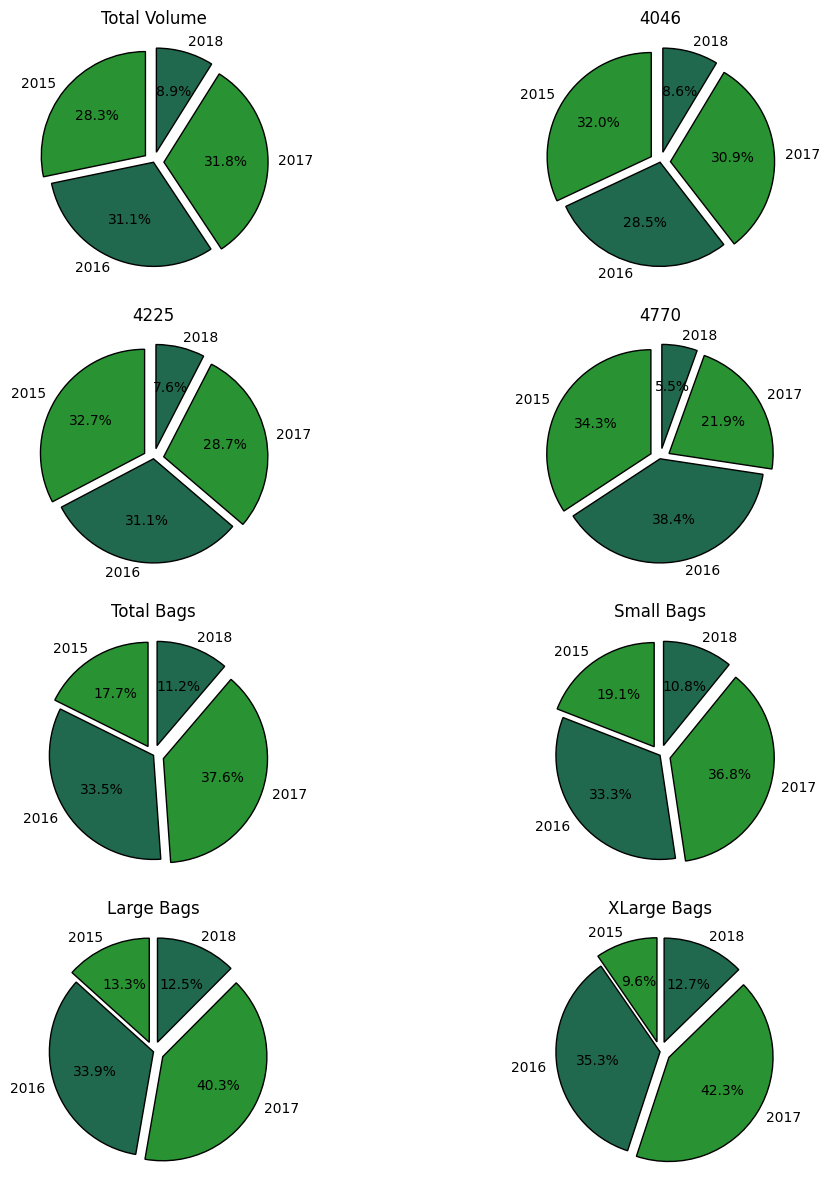

In [18]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (12,12))

for i in range(len(numerical_features)):
    plt.subplot(4,2,i + 1)
    plt.pie(year_numerical_features_percentage[i],labels = ['2015','2016','2017','2018'],autopct = '%1.1f%%',
            startangle = 90, explode = (0.1,0,0.1,0.1), colors = color1, 
            wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
    title = numerical_features[i] 
    plt.title(title);
fig.tight_layout(pad = 1)

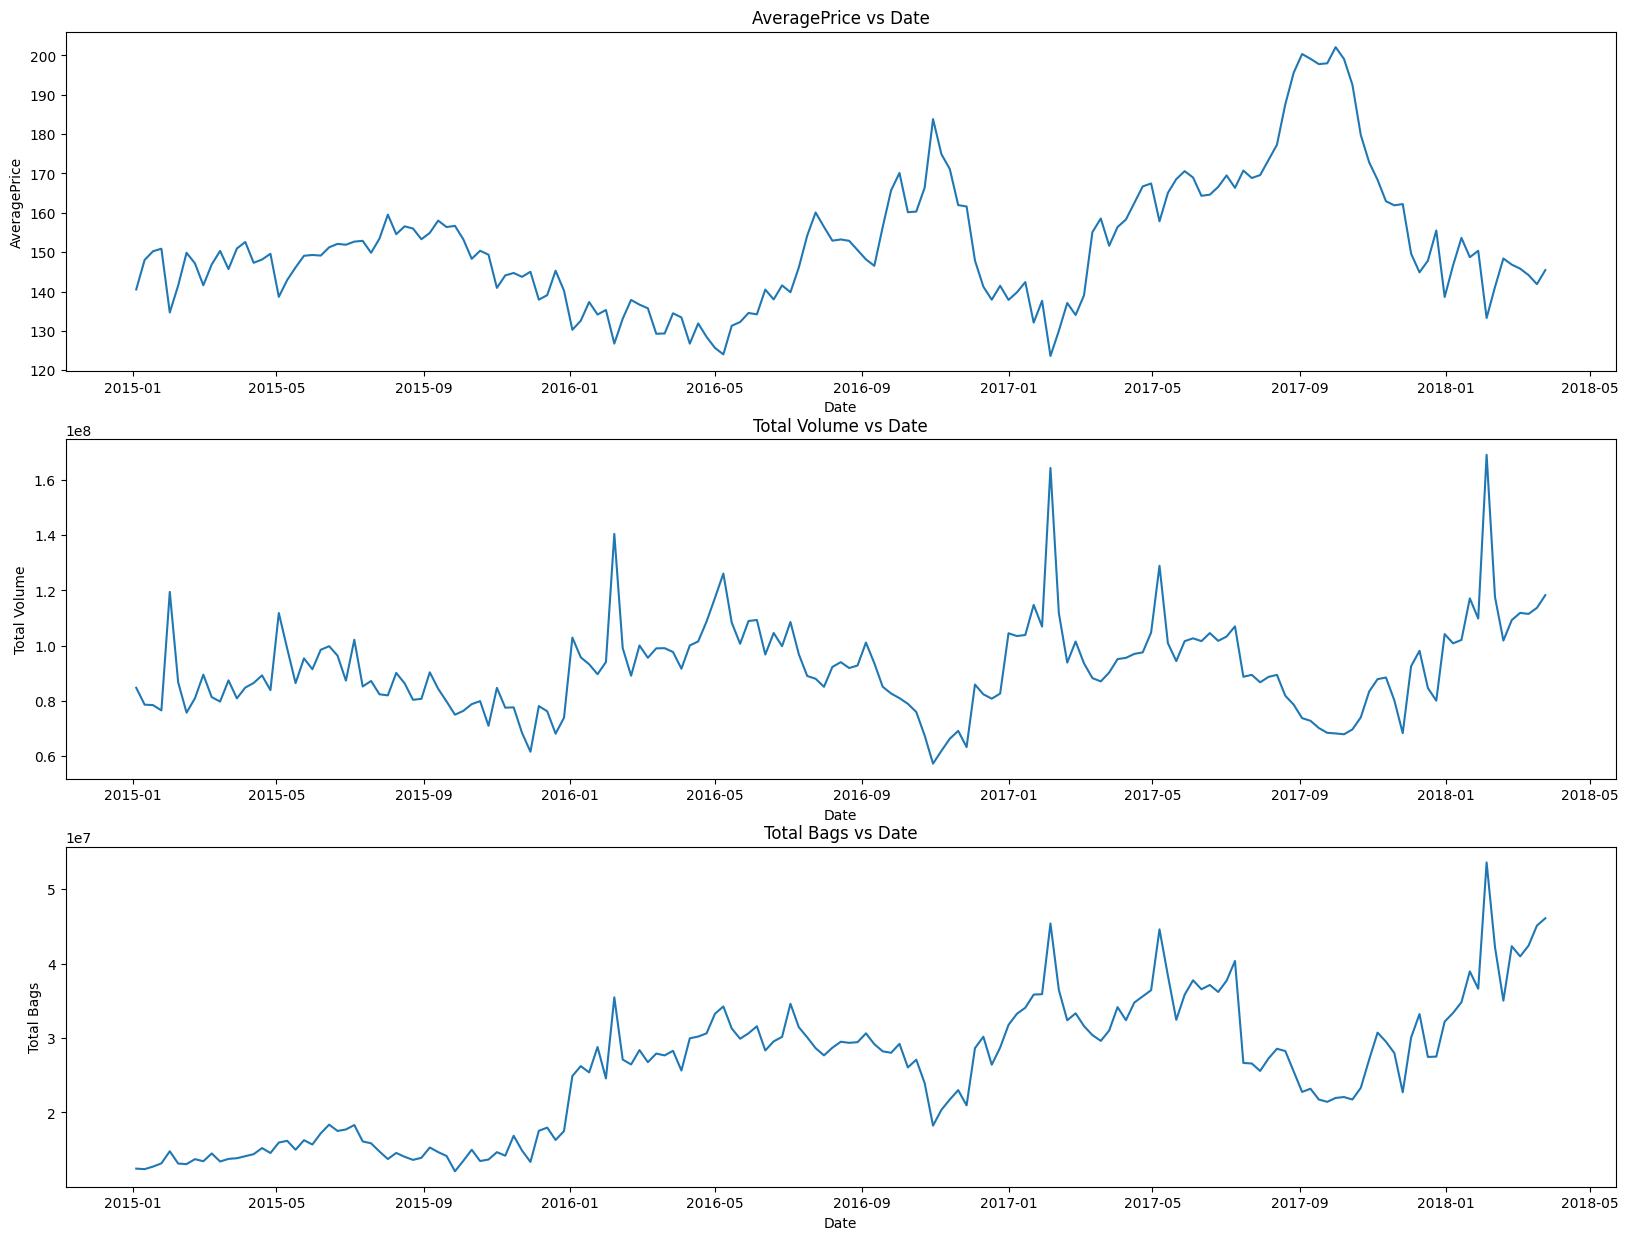

In [19]:
# Numerical Features vs Date :

l1 = ['AveragePrice','Total Volume','Total Bags']
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (20,15))
for i in range(len(l1)):
    
    plt.subplot(3,1,i+1)
    sns.lineplot(x = df1.index,y = l1[i],data = df1)
    title = l1[i] + ' vs Date'
    plt.title(title);

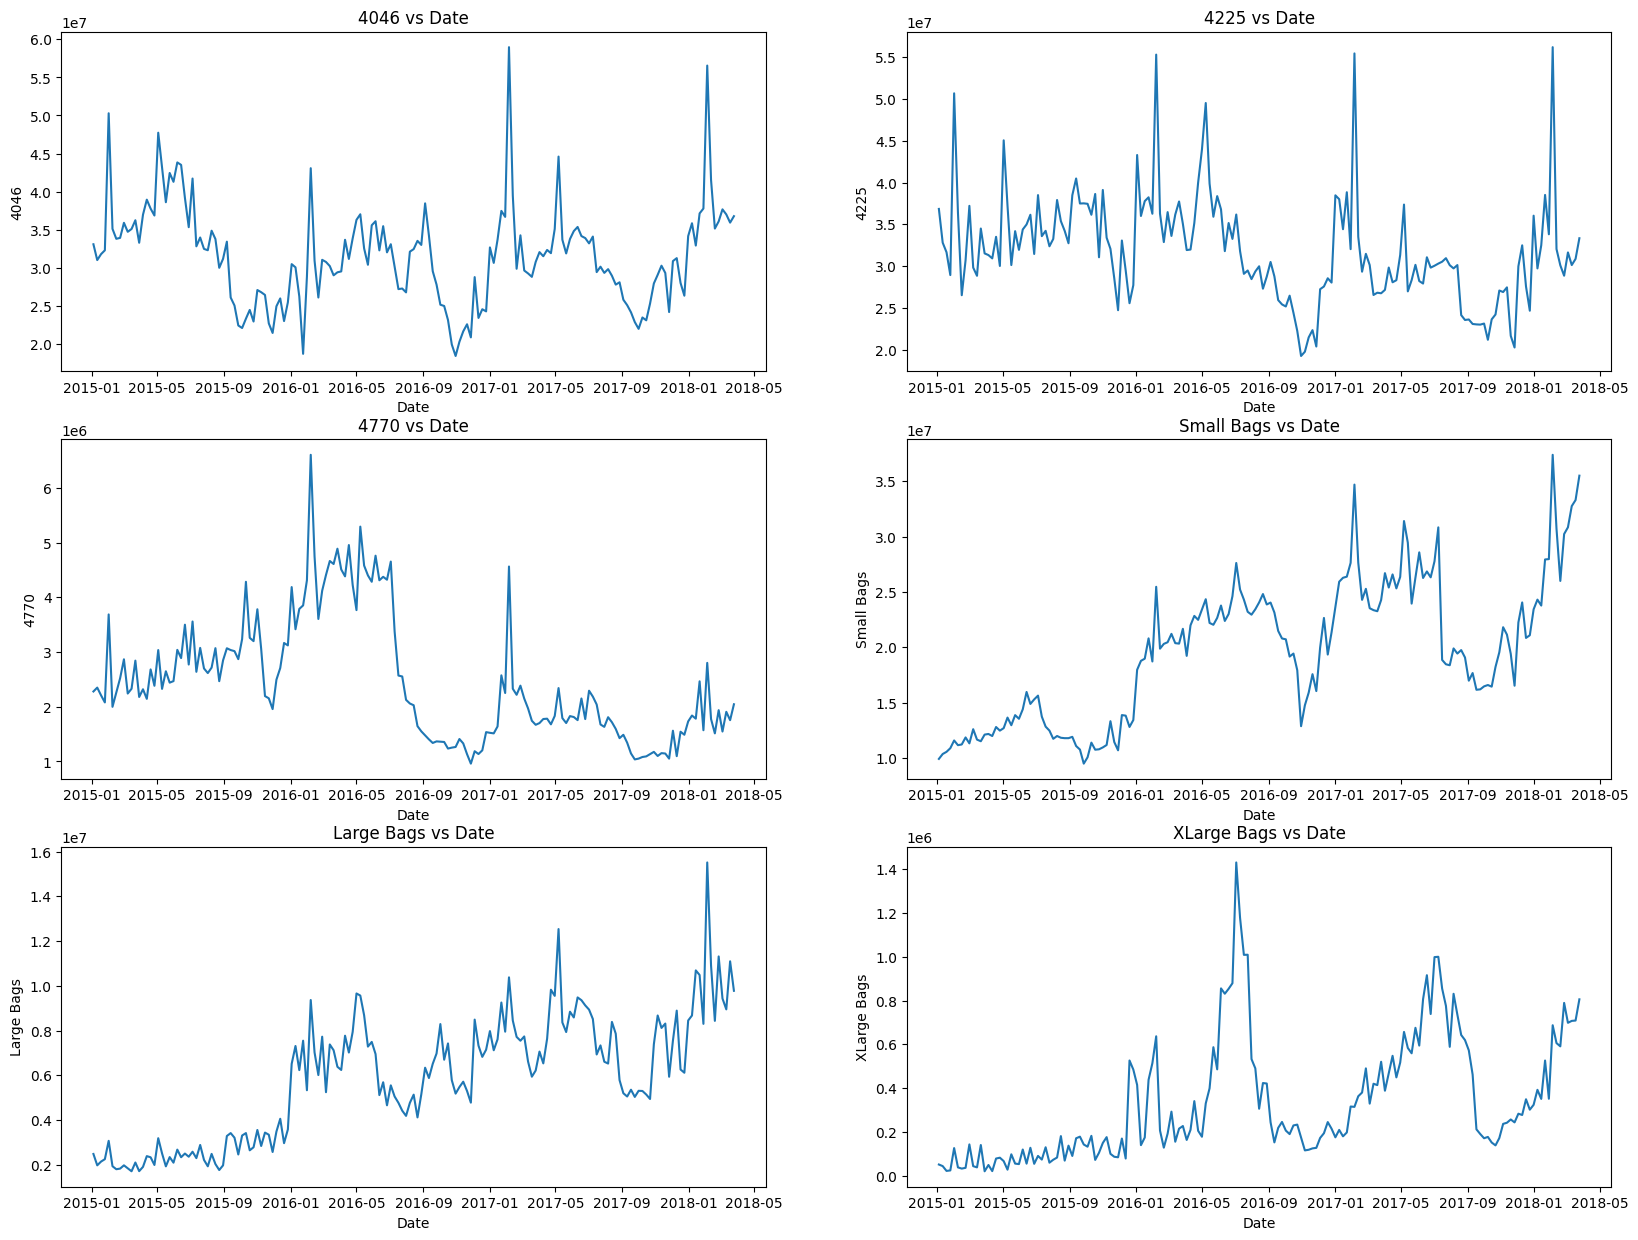

In [20]:
l2 = ['4046','4225','4770','Small Bags','Large Bags','XLarge Bags']

fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20,15))
for i in range(len(l2)):
    
    plt.subplot(3,2,i+1)
    sns.lineplot(x = df1.index,y = l2[i],data = df1)
    title = l2[i] + ' vs Date'
    plt.title(title);

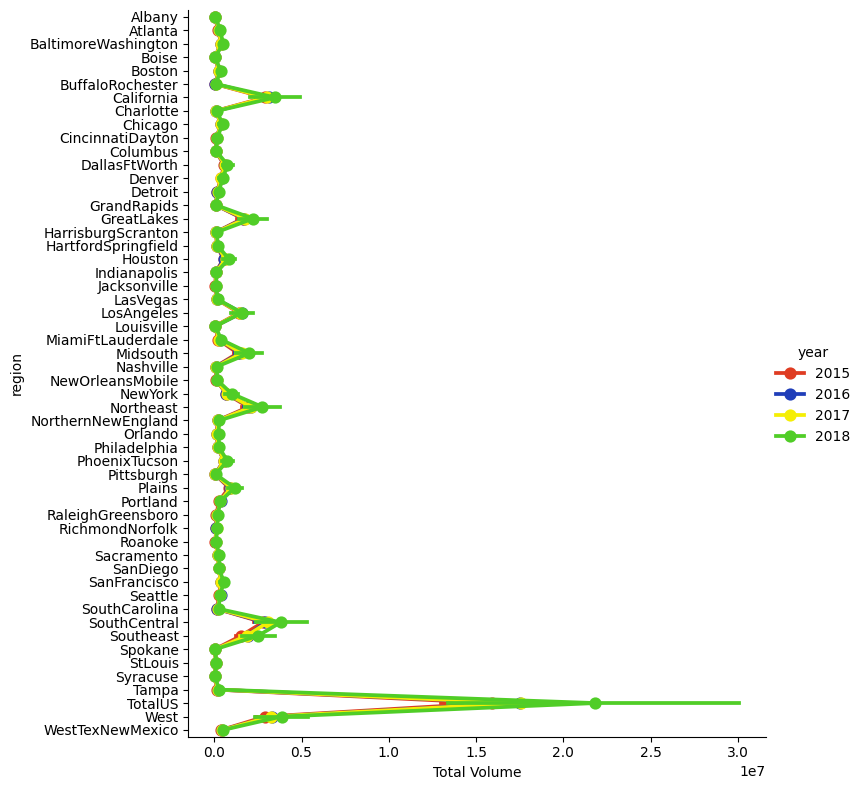

In [21]:
# Total Volume vs region w.r.t year :

color2 = ['#DF3C22','#203EB9', '#F5EE04','#50CD27']

sns.catplot(
    x='Total Volume',
    y='region',
    data=data,
    hue='year',
    height=8,
    palette=color2,
    kind='point'
)

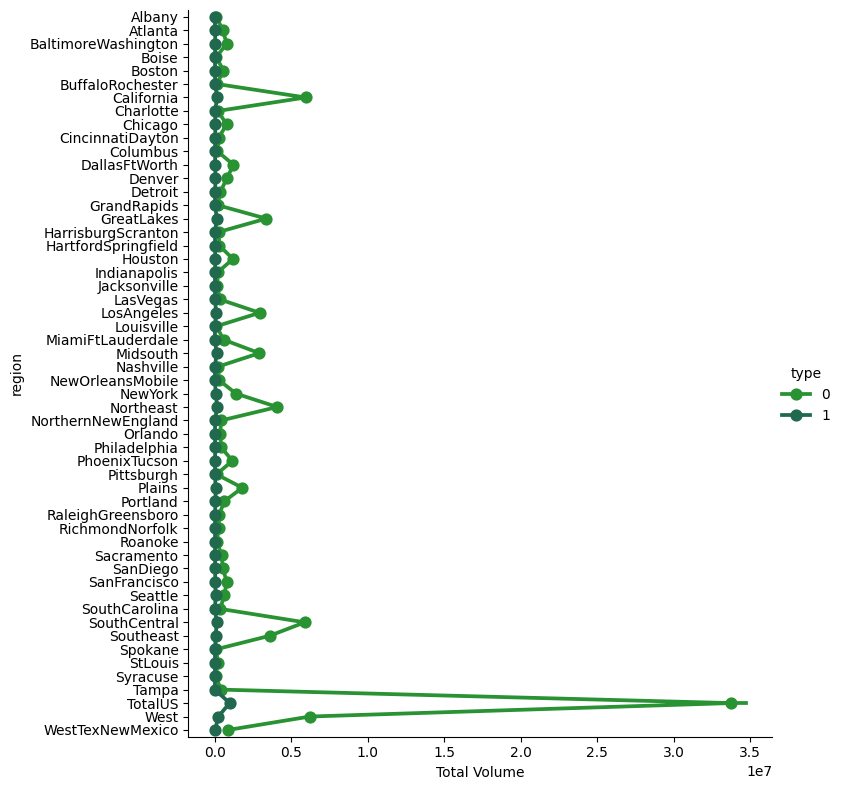

In [22]:
# Total Volume vs region w.r.t type :
    
sns.catplot(
    x='Total Volume',
    y='region',
    data=data,
    hue='type',
    height=8,
    palette=color1,
    kind='point'
)

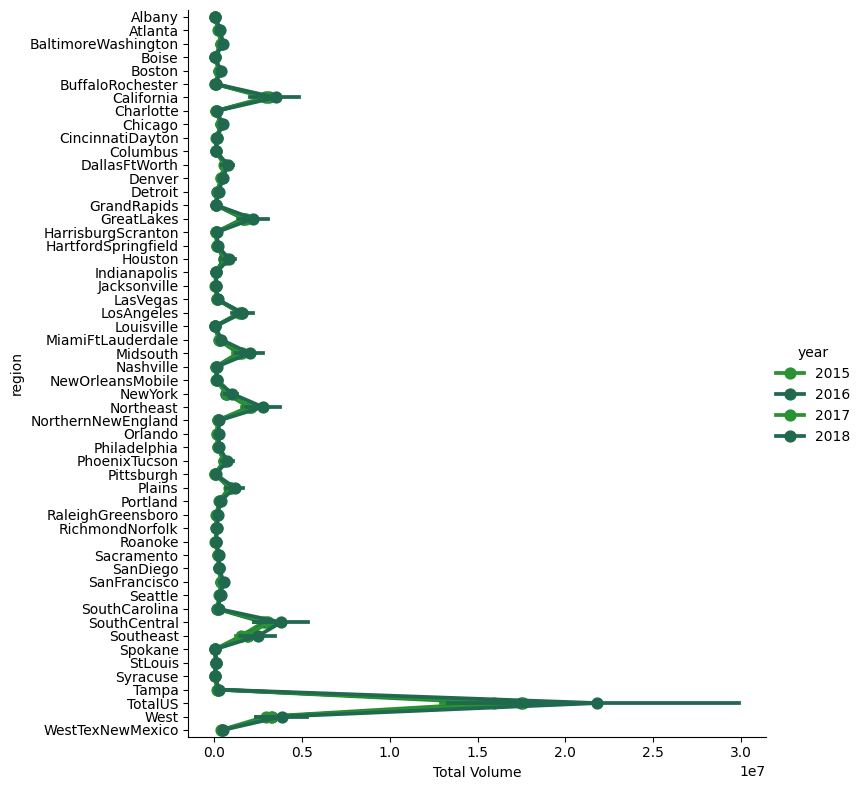

In [23]:
# Total Bags vs region w.r.t year :
    
sns.catplot(
    x='Total Volume',
    y='region',
    data=data,
    hue='year',
    height=8,
    palette=color1,
    kind='point'
)

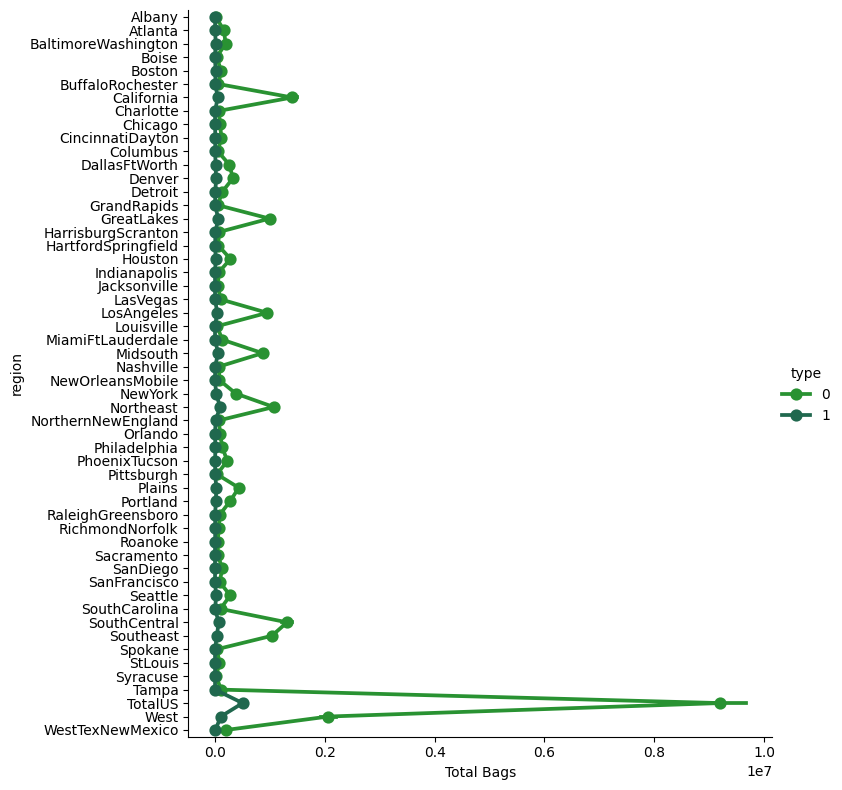

In [24]:
# Total Bags vs region w.r.t type :
    
sns.catplot(
    x='Total Bags',
    y='region',
    data=data,
    hue='type',
    height=8,
    palette=color1,
    kind='point'
)

Time Series Analysis

In [25]:
df1 = data.copy(deep = True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1 = df1.resample('W').sum()
df1.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,140.54,84674337.20,33098258.74,36851038.43,2278818.64,12446221.39,9910008.90,2485655.90,50556.59,54,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-11,148.03,78555807.24,31024164.99,32808429.84,2349167.45,12374044.96,10352936.42,1977832.00,43276.54,54,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-18,150.24,78388784.08,31802706.86,31662041.93,2208250.55,12715784.74,10548854.11,2145586.13,21344.50,54,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-01-25,150.89,76466281.07,32305132.87,28929122.37,2078378.86,13153646.97,10877316.95,2252815.92,23514.10,54,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...
2015-02-01,134.68,119453235.25,50292988.96,50696230.48,3687489.31,14776526.50,11576833.65,3073989.39,125703.46,54,217620,AlbanyAtlantaBaltimoreWashingtonBoiseBostonBuf...


In [26]:
l3 = list(df1.columns)
l3.remove('AveragePrice')

df1.drop(columns = l3,inplace =True)
df1.head()

,AveragePrice
Date,
2015-01-04,140.54
2015-01-11,148.03
2015-01-18,150.24
2015-01-25,150.89
2015-02-01,134.68


In [27]:
# Supportive Functions for TIme Series Analysis :

def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [28]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

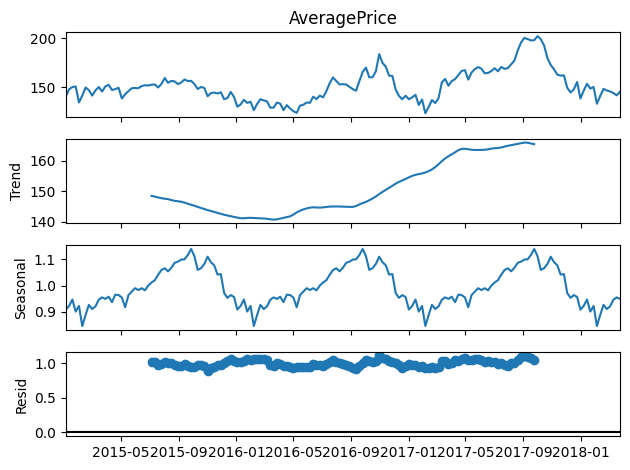

In [29]:
dec = sm.tsa.seasonal_decompose(df1['AveragePrice'], model = 'multiplicative').plot()
plt.show();

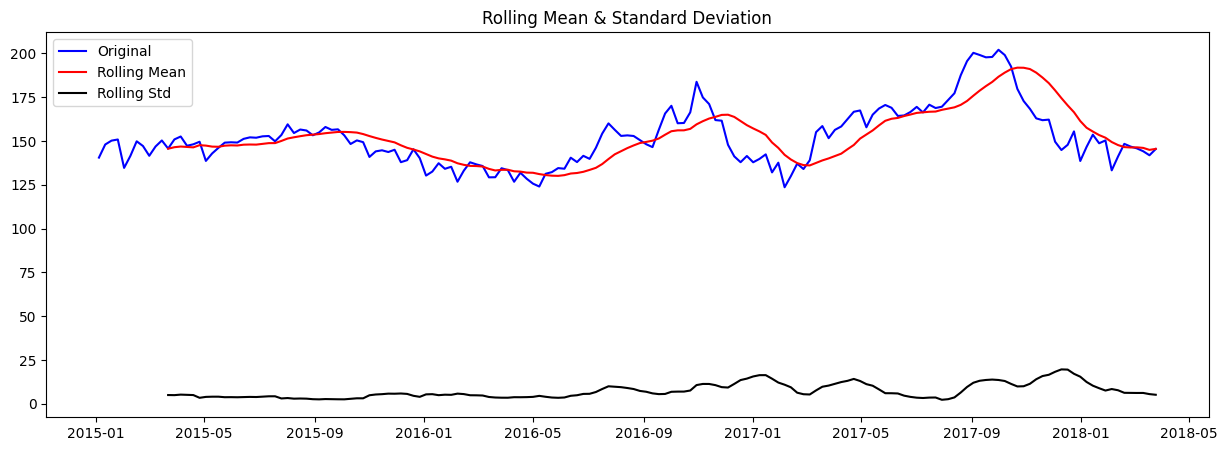

Results of Dickey-Fuller Test:
Test Statistic                 -2.36
p-value                         0.15
#Lags Used                      0.00
Number of Observations Used   168.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [30]:
test_stationarity(df1['AveragePrice'])

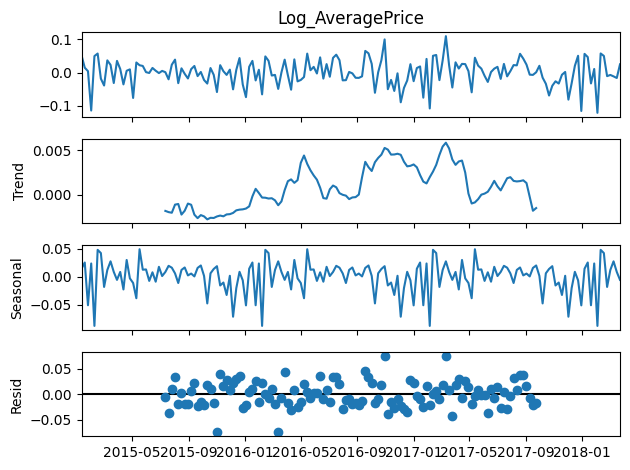

In [31]:
df1['Log_AveragePrice'] = np.log(df1['AveragePrice'])
df1_log_diff = df1['Log_AveragePrice'].diff()
df1_log_diff = df1_log_diff.dropna()

dec = sm.tsa.seasonal_decompose(df1_log_diff,period = 52).plot()
plt.show()

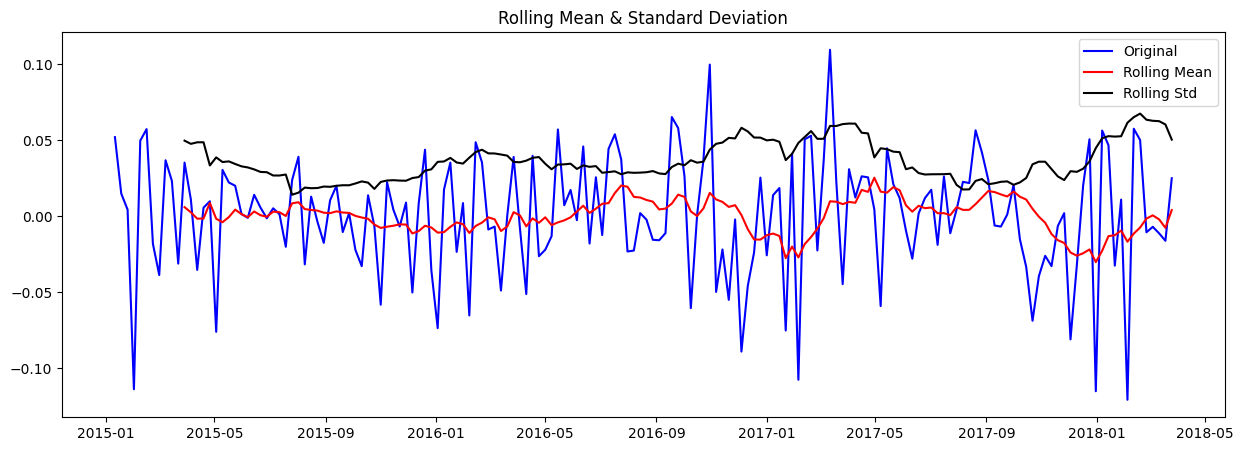

Results of Dickey-Fuller Test:
Test Statistic                -13.82
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   167.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [32]:
test_stationarity(df1_log_diff)

Modeling

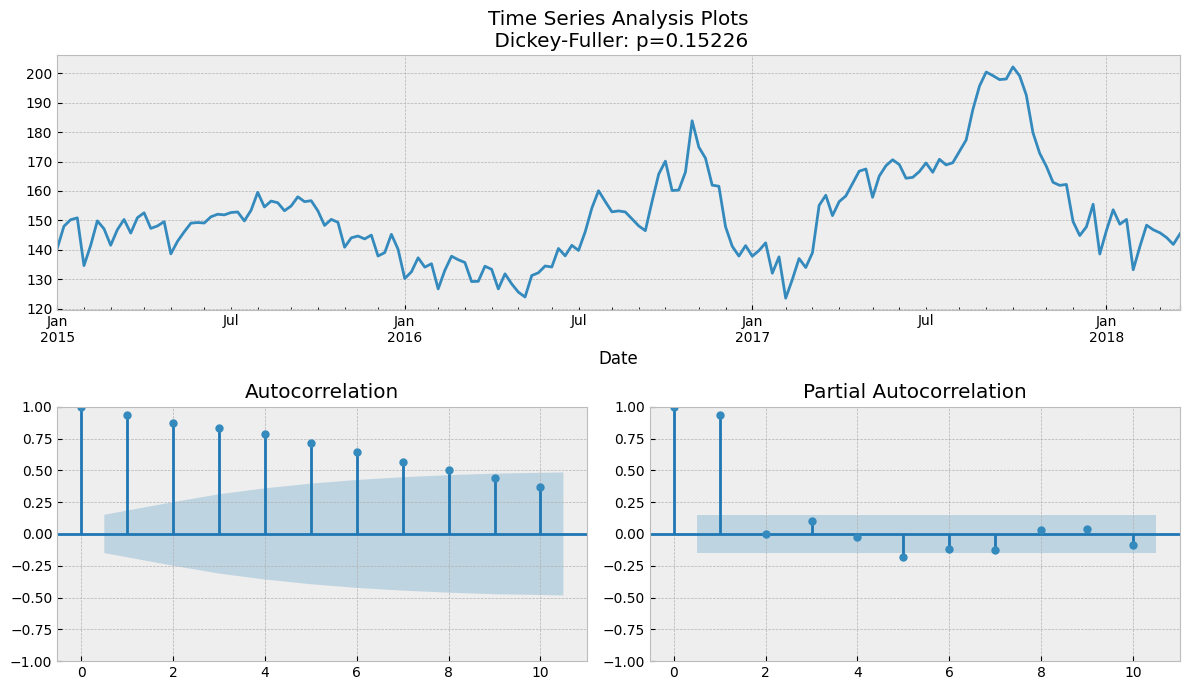

In [33]:
# ARIMA - Auto Regressive Integrated Moving Average

tsplot(df1['AveragePrice'],lags = 10)

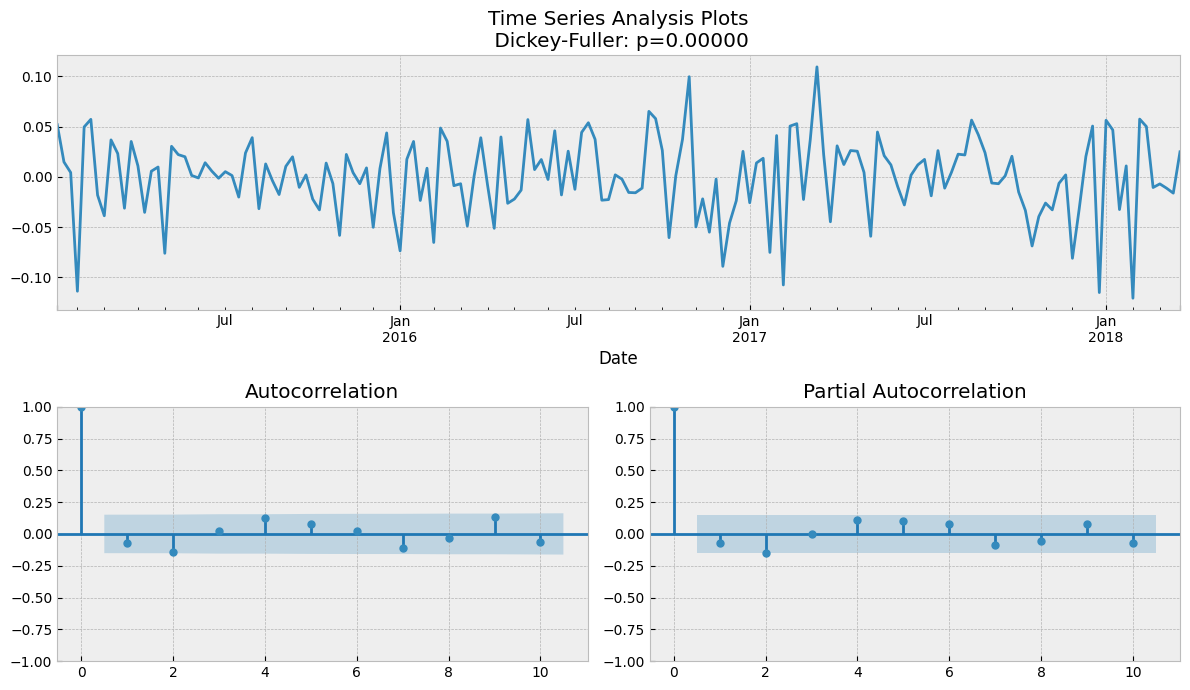

In [34]:
tsplot(df1_log_diff,lags = 10)

In [35]:
model = ARIMA(df1['Log_AveragePrice'],order = (1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       Log_AveragePrice   No. Observations:                  169
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 308.987
Date:                Wed, 27 Aug 2025   AIC                           -609.975
Time:                        20:36:14   BIC                           -597.479
Sample:                    01-04-2015   HQIC                          -604.904
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1476      0.785     -0.188      0.851      -1.687       1.392
ma.L1          0.0719      0.776      0.093      0.926      -1.449       1.593
ma.L2         -0.1238      0.099     -1.251      0.2

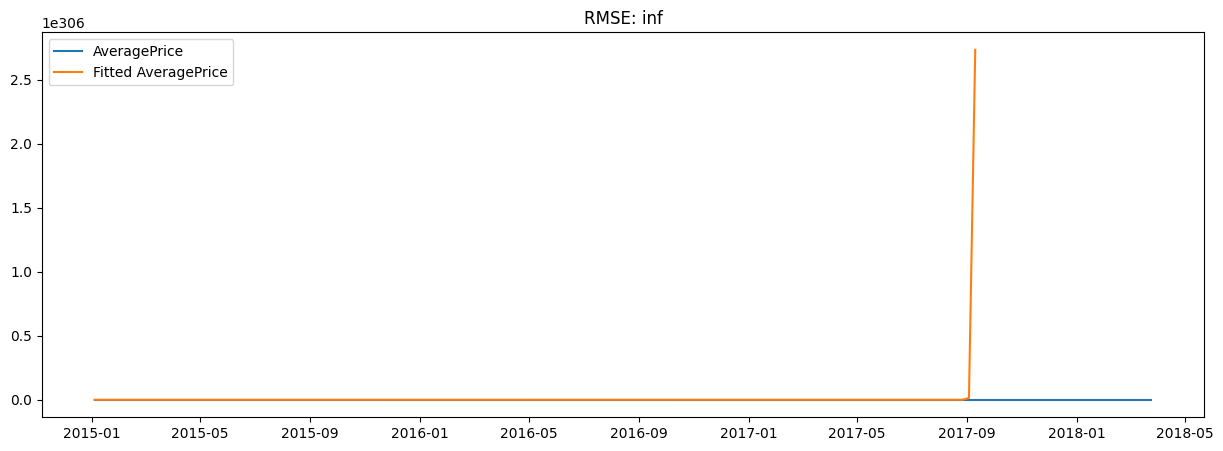

In [36]:
# Fitted values of the model
predictions_ARIMA = pd.Series(model_fit.fittedvalues, copy=True)

# Reversing the 1st order Differencing by taking cumulative sum 
predictions_ARIMA_cumsum = predictions_ARIMA.cumsum()

# Creating a series with the same length as the original 'Log_AveragePrice'
# All the elements of this new series are same as the 1st element of the original 'Log_AveragePrice'
expected_log_values = pd.Series(df1['Log_AveragePrice'].iloc[0], index = df1['Log_AveragePrice'].index)

# Adding the elements of this newly created series with the cumulative sum series
expected_log_values = expected_log_values.add(predictions_ARIMA_cumsum,fill_value = 0)

# Taking log of the above series for getting the original values 
predictions_ARIMA_final = np.exp(expected_log_values)

fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'AveragePrice')
plt.plot(predictions_ARIMA_final,label = 'Fitted AveragePrice');
plt.legend(loc="upper left")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_final - df1['AveragePrice'])**2)/len(df1['AveragePrice'])));

In [37]:
size = int(len(df1) - 30)
train, test = df1['Log_AveragePrice'][0:size], df1['Log_AveragePrice'][size:len(df1)]

print('\t ARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,2))
    model_fit = model.fit()
    
    # Forecast 1 step ahead
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))

	 ARIMA MODEL : In - Sample Forecasting 

predicted = 193.442781, expected = 200.360000
predicted = 198.861548, expected = 199.140000
predicted = 198.350158, expected = 197.790000
predicted = 197.806514, expected = 198.000000
predicted = 198.054292, expected = 202.100000
predicted = 201.822191, expected = 199.080000
predicted = 198.778893, expected = 192.550000
predicted = 193.253856, expected = 179.770000
predicted = 181.078877, expected = 172.820000
predicted = 174.470396, expected = 168.380000
predicted = 169.294217, expected = 162.950000
predicted = 163.574187, expected = 161.910000
predicted = 162.489552, expected = 162.230000
predicted = 162.371554, expected = 149.620000
predicted = 149.802573, expected = 144.880000
predicted = 145.945342, expected = 147.850000
predicted = 148.235768, expected = 155.510000
predicted = 155.321114, expected = 138.620000
predicted = 138.370615, expected = 146.640000
predicted = 147.702894, expected = 153.640000
predicted = 152.315428, expected = 148

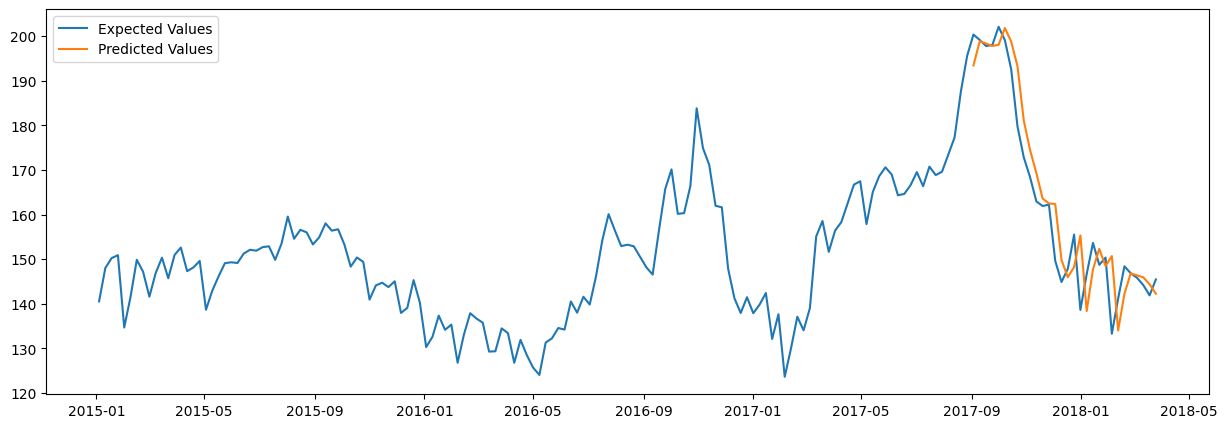

In [38]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'Expected Values')
plt.plot(np.exp(predictions_series),label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [39]:
error = np.sqrt(mean_squared_error(np.exp(test),np.exp(predictions)))
print('Test RMSE: %.4f' % error)
predictions_series = pd.Series(np.exp(predictions), index = test.index)

Test RMSE: 7.0611


In [40]:
from pandas.tseries.offsets import DateOffset
future_dates = [df1.index[-1] + DateOffset(weeks = x) for x in range(0,52)]

# New dataframe for storing the future values
df2 = pd.DataFrame(index = future_dates[1:],columns = df1.columns)

forecast = pd.concat([df1,df2])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function
2015-01-04,140.54,4.95,NaN,NaN
2015-01-11,148.03,5.00,NaN,NaN
2015-01-18,150.24,5.01,NaN,NaN
2015-01-25,150.89,5.02,NaN,NaN
2015-02-01,134.68,4.90,NaN,NaN


In [41]:
f1 = np.array(np.exp(model_fit.forecast(steps = 51)))

for i in range(len(f1)):
    forecast.iloc[169 + i,2] = f1[i]
forecast.tail()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function
2019-02-17,NaN,NaN,142.46,NaN
2019-02-24,NaN,NaN,142.46,NaN
2019-03-03,NaN,NaN,142.46,NaN
2019-03-10,NaN,NaN,142.46,NaN
2019-03-17,NaN,NaN,142.46,NaN


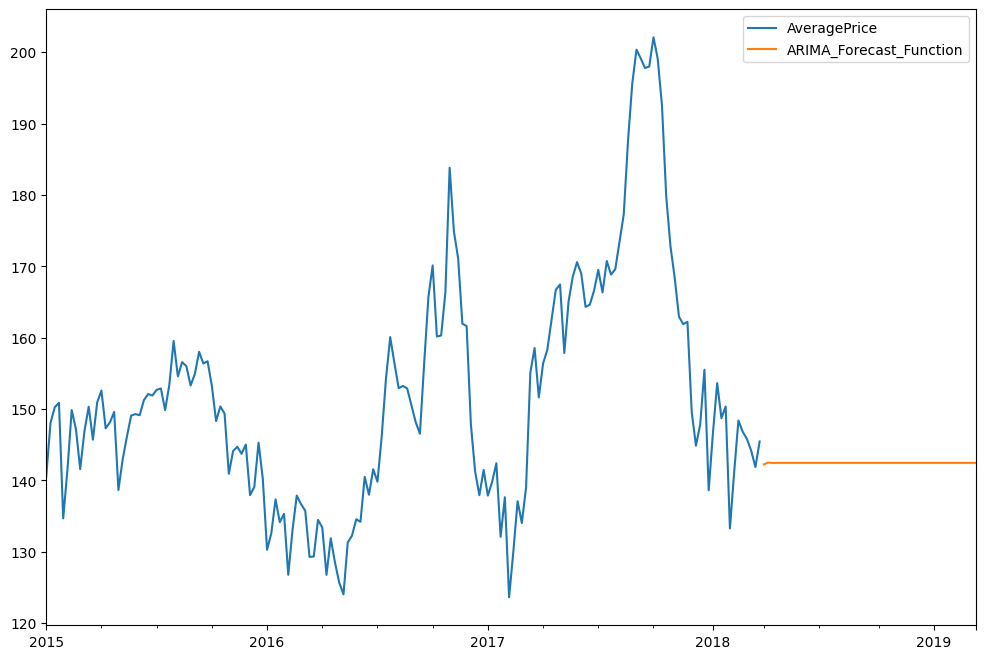

In [42]:
forecast[['AveragePrice','ARIMA_Forecast_Function']].plot(figsize = (12,8));

In [43]:
f2 = np.array(np.exp(model_fit.predict(start = 169,end = 219,typ = 'levels')))

for i in range(51):
    forecast.iloc[169 + i,3] = f2[i]
forecast.tail()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function
2019-02-17,NaN,NaN,142.46,142.46
2019-02-24,NaN,NaN,142.46,142.46
2019-03-03,NaN,NaN,142.46,142.46
2019-03-10,NaN,NaN,142.46,142.46
2019-03-17,NaN,NaN,142.46,142.46


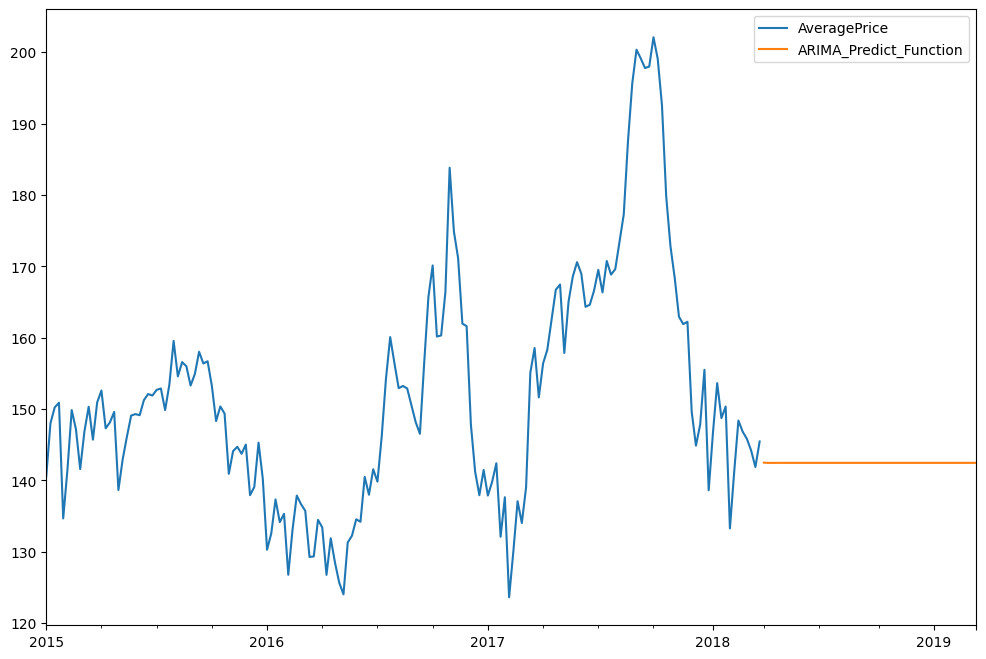

In [44]:
forecast[['AveragePrice','ARIMA_Predict_Function']].plot(figsize = (12,8));

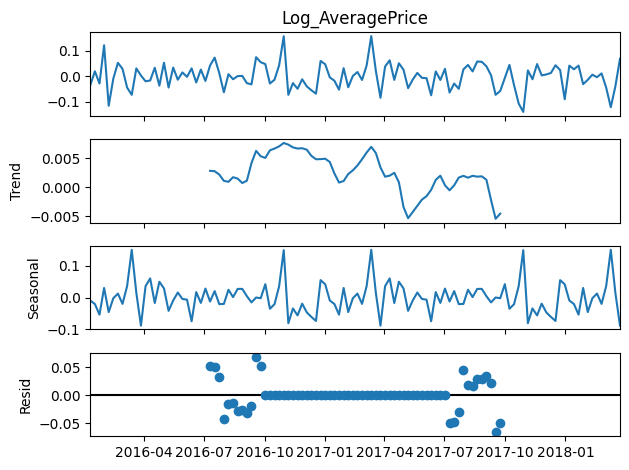

In [45]:
# SARIMA - Seasonal Auto Regressive Integrated Moving Average

df1_log_diff_seas = df1_log_diff.diff(52)
df1_log_diff_seas = df1_log_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(df1_log_diff_seas).plot()
plt.show()

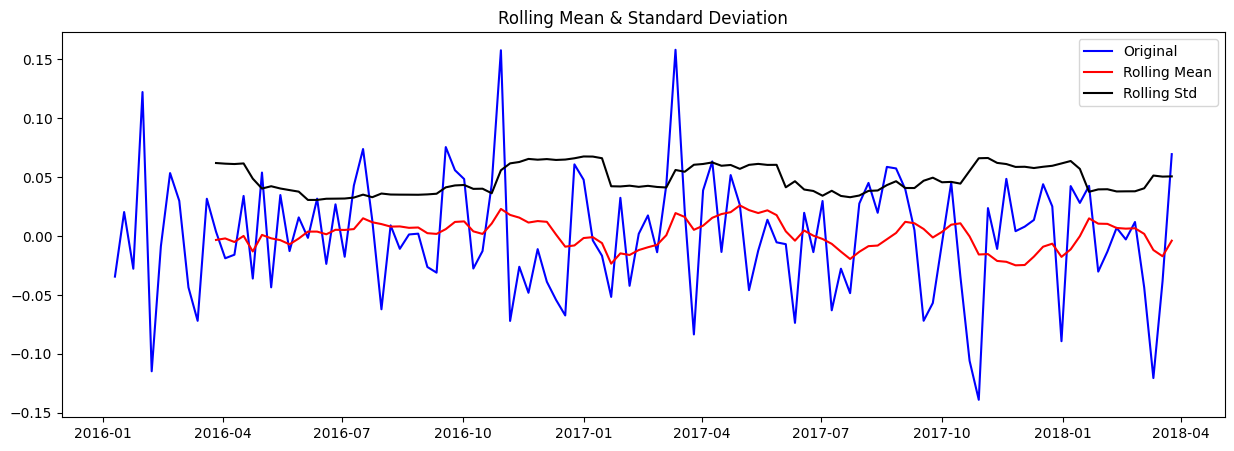

Results of Dickey-Fuller Test:
Test Statistic                 -4.60
p-value                         0.00
#Lags Used                     11.00
Number of Observations Used   104.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [46]:
test_stationarity(df1_log_diff_seas)

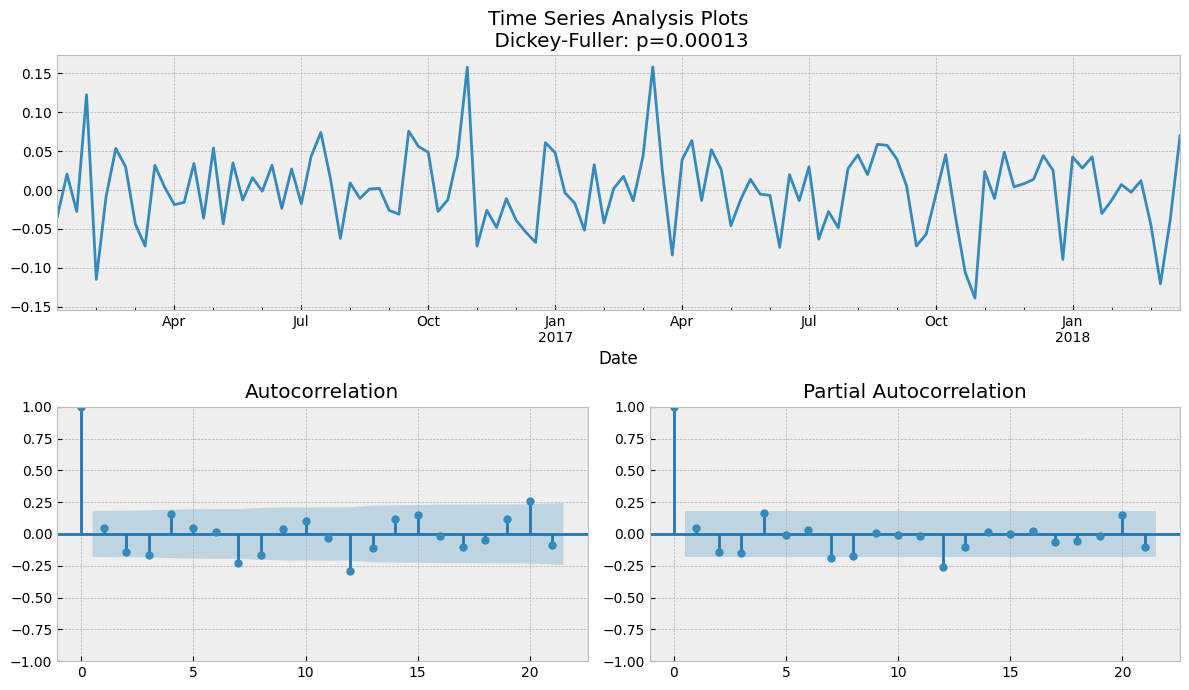

In [47]:
tsplot(df1_log_diff_seas)

In [48]:
model = sm.tsa.statespace.SARIMAX(df1['Log_AveragePrice'],order = (1,1,2),seasonal_order = (0,1,0,52))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                    Log_AveragePrice   No. Observations:                  169
Model:             SARIMAX(1, 1, 2)x(0, 1, [], 52)   Log Likelihood                 184.923
Date:                             Wed, 27 Aug 2025   AIC                           -361.847
Time:                                     20:36:23   BIC                           -350.832
Sample:                                 01-04-2015   HQIC                          -357.376
                                      - 03-25-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7830      0.164      4.782      0.000       0.462       1.104
ma.L1         -0.7559      

In [49]:
size = int(len(df1) - 30)
train, test = df1['Log_AveragePrice'][0:size], df1['Log_AveragePrice'][size:len(df1)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (1,1,2),seasonal_order = (0,1,0,52))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (np.exp(yhat), np.exp(obs)))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 190.129879, expected = 200.360000
predicted = 196.078491, expected = 199.140000
predicted = 211.067703, expected = 197.790000
predicted = 207.489779, expected = 198.000000
predicted = 202.747210, expected = 202.100000
predicted = 190.633910, expected = 199.080000
predicted = 199.388915, expected = 192.550000
predicted = 199.443777, expected = 179.770000
predicted = 199.351127, expected = 172.820000
predicted = 165.329415, expected = 168.380000
predicted = 169.279813, expected = 162.950000
predicted = 154.801263, expected = 161.910000
predicted = 164.735311, expected = 162.230000
predicted = 150.094015, expected = 149.620000
predicted = 144.449600, expected = 144.880000
predicted = 142.819126, expected = 147.850000
predicted = 152.896965, expected = 155.510000
predicted = 151.998048, expected = 138.620000
predicted = 140.270973, expected = 146.640000
predicted = 150.889918, expected = 153.640000
predicted = 143.050027, expected = 14

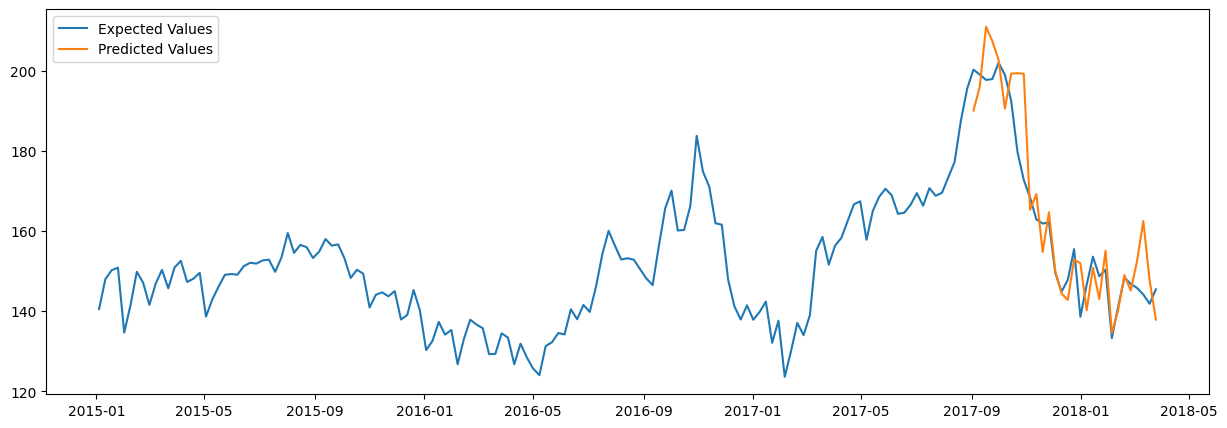

In [50]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df1['AveragePrice'],label = 'Expected Values')
plt.plot(np.exp(predictions_series),label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [51]:
error = np.sqrt(mean_squared_error(np.exp(test),np.exp(predictions)))
print('Test RMSE: %.4f' % error)
predictions_series = pd.Series(np.exp(predictions), index = test.index)

Test RMSE: 9.1082


In [52]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2015-01-04,140.54,4.95,NaN,NaN,NaN,NaN
2015-01-11,148.03,5.00,NaN,NaN,NaN,NaN
2015-01-18,150.24,5.01,NaN,NaN,NaN,NaN
2015-01-25,150.89,5.02,NaN,NaN,NaN,NaN
2015-02-01,134.68,4.90,NaN,NaN,NaN,NaN


In [53]:
f3 = np.array(np.exp(model_fit.forecast(steps = 51)))

for i in range(len(f3)):
    forecast.iloc[169 + i,4] = f3[i]
forecast.tail()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2019-02-17,NaN,NaN,142.46,142.46,140.21,NaN
2019-02-24,NaN,NaN,142.46,142.46,147.40,NaN
2019-03-03,NaN,NaN,142.46,142.46,145.85,NaN
2019-03-10,NaN,NaN,142.46,142.46,144.84,NaN
2019-03-17,NaN,NaN,142.46,142.46,143.22,NaN


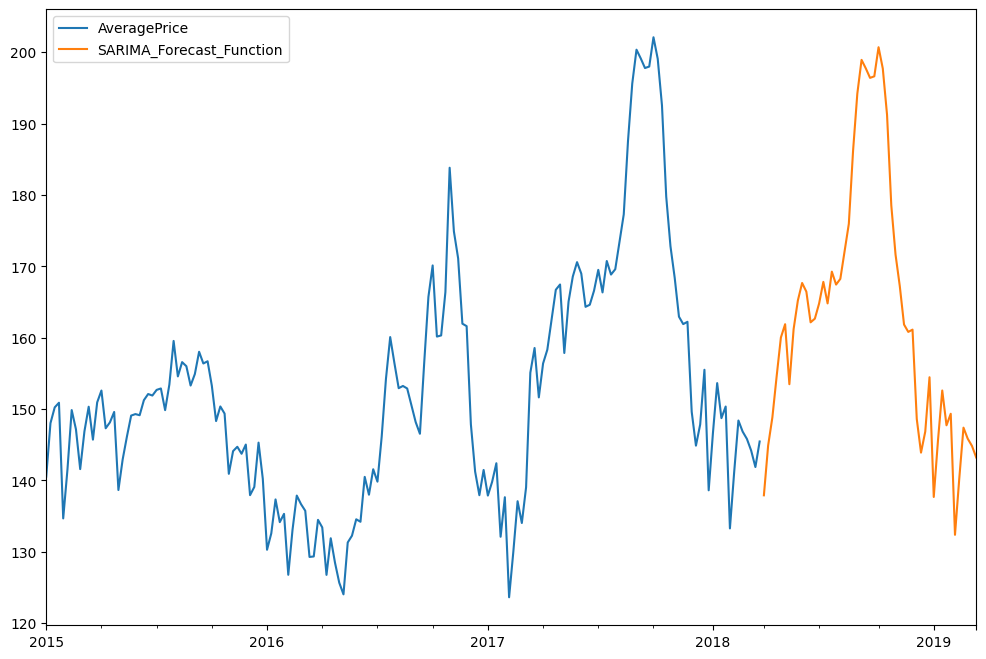

In [54]:
forecast[['AveragePrice','SARIMA_Forecast_Function']].plot(figsize = (12,8));

In [55]:
f4 = np.array(np.exp(model_fit.predict(start = 169,end = 219,typ = 'levels')))

for i in range(51):
    forecast.iloc[169 + i,5] = f4[i]
forecast.tail()

,AveragePrice,Log_AveragePrice,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
2019-02-17,NaN,NaN,142.46,142.46,140.21,147.40
2019-02-24,NaN,NaN,142.46,142.46,147.40,145.85
2019-03-03,NaN,NaN,142.46,142.46,145.85,144.84
2019-03-10,NaN,NaN,142.46,142.46,144.84,143.22
2019-03-17,NaN,NaN,142.46,142.46,143.22,140.92


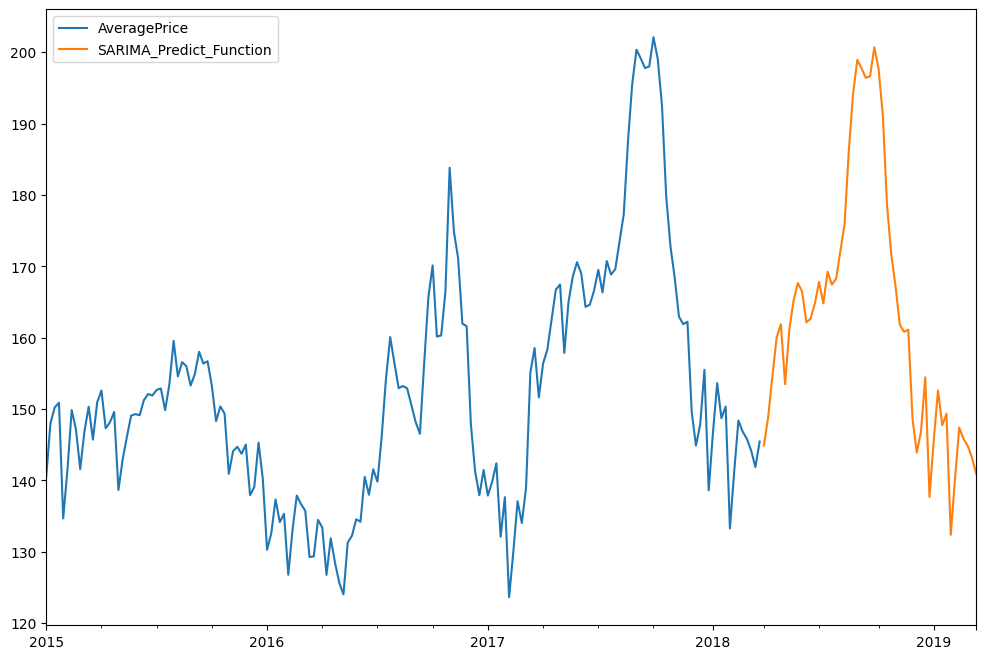

In [56]:
forecast[['AveragePrice','SARIMA_Predict_Function']].plot(figsize = (12,8));

In [57]:
sum(f3) == sum(f4)

False

Conclusion